# ECON408: Final Practice Problems

Instructor: Jesse Perla, UBC

In [1]:
using Distributions, Plots, LaTeXStrings, LinearAlgebra, Statistics, Random, QuantEcon, NLsolve

## Question 1

Consider the original formulation of the asset pricing equations with
the stochastic discount factor $m_{t+1}$ in the [Lucas tree
model](https://julia.quantecon.org/multi_agent_models/markov_asset.html#pricing-a-lucas-tree)

$$
v(X_t) = \beta {\mathbb E}_t \left[ m_{t+1} \frac{d_{t+1}}{d_t} (1 + v(X_{t+1})) \right]
$$

where

$$
m_{t+1} = \beta \frac{u'(c_{t+1})}{u'(c_t)}
$$

Furthermore, we will consider there may be two processes for $m_{t+1}$
and the dividends:

$$
\frac{c_{t+1}}{c_t} = g_c(X_{t+1})
$$

and

$$
\frac{d_{t+1}}{d_t} = g_d(X_{t+1})
$$

With this, the price-dividend ratio equation becomes:

$$
v(X_t) = \beta {\mathbb E}_t \left[ g_c(X_{t+1})^{-\gamma} g_d(X_{t+1}) (1 + v(X_{t+1})) \right]
$$

and if $X_t \in S$ is a Markov chain with transition probabilities
$P(X_t, X_{t+1})$ then the price-dividend ratio equation becomes:

$$
v(x) = \beta \sum_{x'\in S} g_c(x')^{-\gamma} g_d(x') (1 + v(x')P(x,x')
$$

The price of the asset itself follows,

$$
p(x) = \beta \sum_{x'\in S} g_c(x')^{-\gamma} (g_d(x') x + p(x'))P(x,x')
$$

### Part (a)

In the original lucas tree model, we had that $g_c(x) = g_d(x) = g(x)$.
i.e., perfect correlation between the consumption and dividend growth
processes.

This meant we could write the price-dividend ratio equation as:

$$
v(x) = \beta \sum_{x'\in S} g(x')^{1 -\gamma} (1 + v(x'))P(x,x')
$$

And if we stack up the $v(x)$ as a vector for each $x \in S$ then we can
write this as a linear system, define,

$$
M_{ij} \equiv g(x_j)^{1 - \gamma} P_{ij}
$$

Then the recursive equation (with $\mathbb{1}$ a stack of ones) is $$
v = \beta M (\mathbb{1} + v)
$$

with solution

$$
v = \left( I - \beta M \right)^{-1} \beta M \mathbb{1}
$$

Putting this into code with a discretized Markov chain from an AR(1)
process, we had

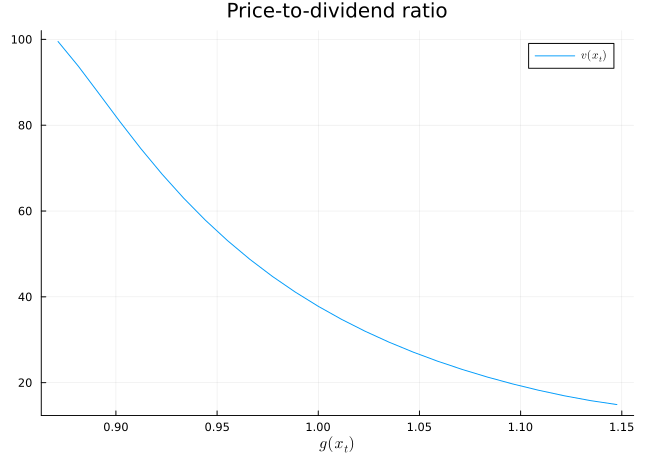

In [2]:
# Do not modify this code directly
function lucas_tree_model(;rho = 0.9, sigma = 0.02, n = 25, beta = 0.96,
                            gamma = 2.0)
    mc = tauchen(n, rho, sigma) # tauchen's method discretizing an AR(1), but could be anything
    return (;beta, gamma, n, x = mc.state_values, g_x = exp.(mc.state_values), P = mc.p, mc)
end

function lucas_tree_v(mod)
    (;x, P, beta, gamma) = mod
    M = [exp(x[j])^(1-gamma) * P[i,j]  for i in eachindex(x), j in eachindex(x)]
    v = (I - beta * M) \ (beta * M * ones(length(x))) # i.e. inv(I - beta * M) * (beta * M * ones(length(x)))

    # Alternatively: can use broadcasting for the M 
    # x_gamma = exp.(x) .^ (1 - gamma); M = x_gamma' .* P
    # Alternatively, equivalent to summing over rows ex-post
    # v = (I - beta * M) \ sum(beta * M, dims = 2)

    return (;M, v)
end

mod = lucas_tree_model(;rho = 0.9) # change default arguments here.
sol = lucas_tree_v(mod)
plot(mod.g_x, sol.v, xlabel = L"g(x_t)", label = L"v(x_t)", title="Price-to-dividend ratio")

Change this code to plot the price-dividend ratio equation for a smaller
autocorrelation of $\rho = 0.1$.

In [3]:
# Modify your code here

Interpret differences in the equation, including the scale and the slope

(double click to edit your answer)

### Part (b)

Now, suppose we want to modify the original model so that the growth
rate of dividends is **inversely correlated** with the growth rate of
consumption. Specifically, let the relationship between consumption and
dividends be as follows:

$$
c_{t+1} = g(X_{t+1}) c_t \quad \text{and} \quad d_{t+1} = {g(-X_{t+1})}
$$

Because $g(X_{t+1}) = \exp(X_{t+1})$, this means we have

$$
m_{t+1} = \beta \exp(X_{t+1})^{-\gamma}
$$

and

$$
\frac{d_{t+1}}{d_t} = \frac{1}{\exp(X_{t+1})}
$$

What is the new price-dividend ratio equation? You can write this out in
LaTeX or keep it simple and describe the changes relative to the
previous equation.

(double click to edit your answer)

### Part (c)

Take the following code from above for the standard Lucas tree (with
perfectly correlated growth rate of dividends and consumption of that
asset) and modify it to solve for the price-dividend ratio equation for
the new model using the formula above. Note some small changes in the
parameters

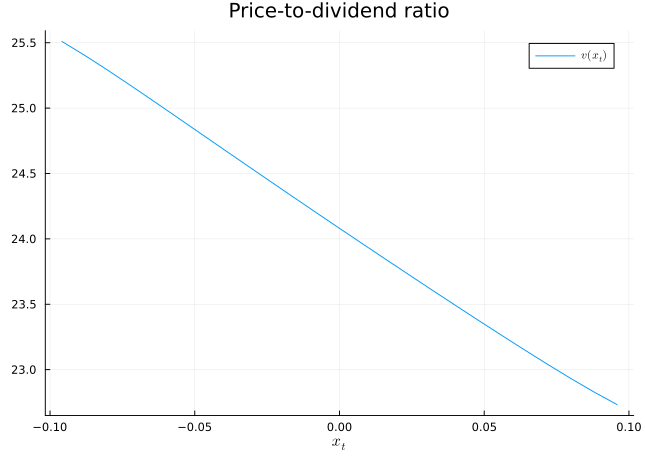

In [7]:
# modify here
function new_lucas_tree_model(;rho = 0.7, sigma = 0.02, n = 25, beta = 0.96,
                            gamma = 2.0)
    mc = tauchen(n, rho, sigma) # tauchen's method discretizing an AR(1), but could be anything
    return (;beta, gamma, n, x = mc.state_values, g_x = exp.(mc.state_values), P = mc.p, mc)
end

function new_lucas_tree_v(mod)
    (;x, P, beta, gamma) = mod
    M = [exp(x[j])^(1-gamma) * P[i,j]  for i in eachindex(x), j in eachindex(x)]
    v = (I - beta * M) \ (beta * M * ones(length(x))) # i.e. inv(I - beta * M) * (beta * M * ones(length(x)))

    @assert maximum(abs, eigvals(M)) < 1/beta # More sensitive to explosive solutions
    # Alternatively: can use broadcasting for the M 
    # x_gamma = exp.(x) .^ (1 - gamma); M = x_gamma' .* P
    # Alternatively, equivalent to summing over rows ex-post
    # v = (I - beta * M) \ sum(beta * M, dims = 2)

    return (;M, v)
end

mod = new_lucas_tree_model(;rho = 0.78, gamma = 1.2)
sol = new_lucas_tree_v(mod)
plot(mod.x, sol.v, xlabel = L"x_t", label = L"v(x_t)", title="Price-to-dividend ratio")

Interpret this result compared to the previous example with perfectly
correlated growth rates. In particular, discuss the differences in
magnitudes.

(double click to edit your answer)

## Question 3

We previously priced a consol (i.e. a bond that pays a constant amount
for eternity) given the standard risk-averse stochastic discount factor
above.

The pricing equation is then

$$
p(x) = {\mathbb E} \left[\beta g(x')^{-\gamma} (\zeta + p(x'))\,|\,x \right]
$$

Which we can implement for a markov chain as

$$
p(x) = \sum_{x'\in S} \left[\beta g(x')^{-\gamma} (\zeta + p(x'))\right]P(x',x)
$$

And in code, if we define $M(x, x') \equiv P(x, x') g(x')^{-\gamma}$,
then the price can be calculated according to the following code:

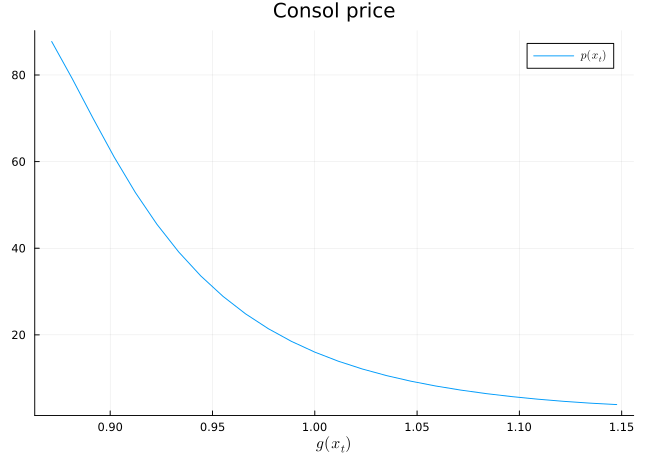

In [10]:
function consol_price(mod)
    (;x, P, beta, gamma, zeta) = mod
    M = [P[i,j] * exp(x[j])^(-gamma) for i in eachindex(x), j in eachindex(x)]
    p = (I - beta * M) \ (beta * zeta * M * ones(length(x))) 

    @assert maximum(abs, eigvals(M)) < 1/beta # More sensitive to explosive solutions
    return (;M, p)
end

function consol_model(;rho = 0.9, sigma = 0.02, n = 25, beta = 0.96,
                            gamma = 2.0, zeta = 1.0)
    mc = tauchen(n, rho, sigma) # tauchen's method discretizing an AR(1), but could be anything
    return (;beta, gamma, zeta, n, x = mc.state_values, g_x = exp.(mc.state_values), P = mc.p, mc)    
end
mod = consol_model(beta = 0.9)
sol = consol_price(mod)
plot(mod.g_x, sol.p, xlabel = L"g(x_t)", label = L"p(x_t)", title="Consol price")

### Part (a)

Now take this code and plot this figure for $\gamma = 0$.

In [11]:
# edit solution here

Interpret the results relative to the case with $\gamma = 2$ If the
solution looks strange, consider the scale.

(double click to edit your answer)

### Part (b)

Take the above code (going back to the baseline $\gamma$) and consider
an option to purchase this $p_s$ (i.e., the strike price). This option
never expires and all price volatility comes from the stochastic
discount factor volatility (i.e. the $m_{t+1}$).

With this, jumping to the recursive formulation and taking the consol
price $p(x)$ as given, the Bellman equation for the option value problem
is

$$
w(x; p_s) = \max\left\{\sum_{x'\in S} \beta g(x')^{-\gamma} P(x', x) w(x'; p_s), p(x) - p_s\right\}
$$

A code implementation of this, using the consol price above, is,

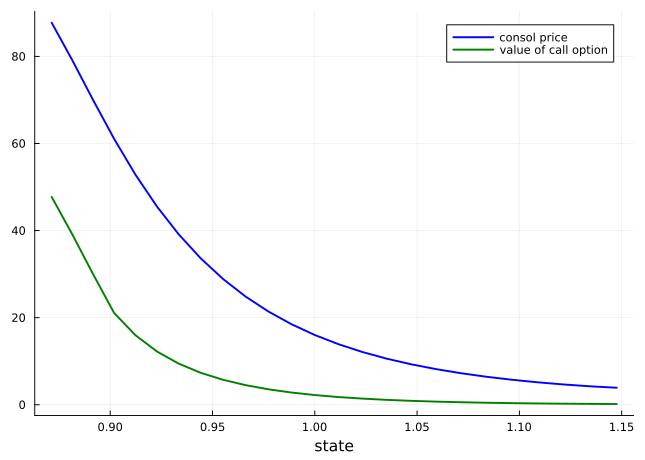

In [14]:
# price of perpetual call on consol bond
function call_option(mod, p_s;iterations = 200, m=2)

    # Simplify names, set up matrices
    (;P, x, beta, gamma) = mod
    M = [P[i,j] * exp(x[j])^(-gamma) for i in eachindex(x), j in eachindex(x)]
    # or more compact, M = P .* exp.(x).^(-gamma)

    # # Compute option price
    sol = consol_price(mod)
    w = zeros(mod.n, 1)

    T(w) = max.(beta * M * w, sol.p .- p_s) # T(w) operator
    w_iv = zeros(mod.n, 1) # initial value
    sol = fixedpoint(T, w_iv; iterations, m) # 
    converged(sol) || error("Failed to converge in $(sol.iterations) iterations")

    return sol.zero
end

mod = consol_model(beta = 0.9)
p = consol_price(mod).p
w = call_option(mod, 40.0)

plot(mod.g_x, p, color = "blue", lw = 2, xlabel = "state", label = "consol price")
plot!(mod.g_x, w, color = "green", lw = 2, label = "value of call option")

Repeat this figure, but now set $p_s = 80$

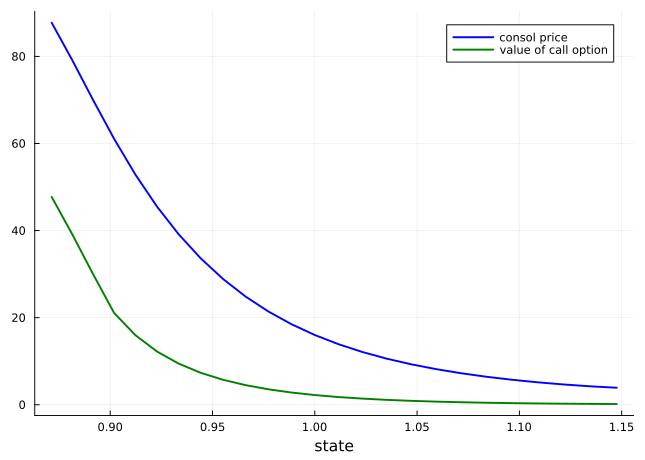

In [15]:
# modify code here
mod = consol_model(beta = 0.9)
p = consol_price(mod).p
w = call_option(mod, 40.0)

plot(mod.g_x, p, color = "blue", lw = 2, xlabel = "state", label = "consol price")
plot!(mod.g_x, w, color = "green", lw = 2, label = "value of call option")

Compare the two cases for the $p_s = 40$ vs. $p_s = 80$.

(double click to edit your answer)

### Part (c)

Now consider a new type of option which expires with probability
$\delta$ each period. If it expires then it provides a choice to execute
the option right before it expires, otherwise it becomes worthless.

The Bellman equation for this new option becomes

$$
w(x; p_s) = \max\left\{\sum_{x'\in S} \beta g(x')^{-\gamma} P(x', x)\left[(1-\delta) w(x'; p_s) + \delta \max\{0, p(x') - p_s\}\right], p(x) - p_s\right\}
$$

Below is the code to implement our original option above. Modify it for
the new option. Hint: almost all of the changes are in the $T(w)$
definition. The code has been modified relative to the case within the
lecture notes to make it easier to change.

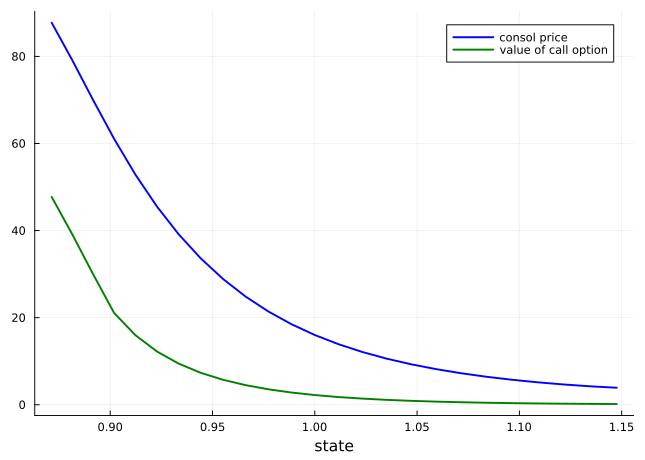

In [18]:
# modify here

function new_consol_model(;rho = 0.9, sigma = 0.02, n = 25, beta = 0.96,
                            delta = 0.1, # NEW parameter added
                            gamma = 2.0, zeta = 1.0)
    mc = tauchen(n, rho, sigma) # tauchen's method discretizing an AR(1), but could be anything
    return (;delta, beta, gamma, zeta, n, x = mc.state_values, g_x = exp.(mc.state_values), P = mc.p, mc)    
end
function new_call_option(mod, p_s;iterations = 200, m=2)
    # Simplify names, set up matrices
    (;P, x, beta, delta, gamma) = mod
    M = [P[i,j] * exp(x[j])^(-gamma) for i in eachindex(x), j in eachindex(x)]
    # or more compact, M = P .* exp.(x).^(-gamma)

    # # Compute option price
    p = consol_price(mod).p
    w = zeros(mod.n, 1)

    # Two other alternatives
    # T(w) = max.(beta * M * w, p .- p_s) # T(w) operator
    # function T(w)
    #     w_new = copy(w)
    #     for i in eachindex(w)
    #         wait_val = sum(beta * exp(x[j])^(-gamma) * P[i,j] * w[j]  for j in eachindex(x))           
    #         w_new[i] = max(wait_val, p[i] - p_s)
    #     end
    #     return w_new
    # end
   
    T(w) = [max(
                sum(beta * exp(x[j])^(-gamma) * P[i,j] * w[j]  for j in eachindex(x)),
                p[i] - p_s
                ) for i in eachindex(w)]

    w_iv = zeros(mod.n, 1) # initial value
    sol = fixedpoint(T, w_iv; iterations, m) # 
    converged(sol) || error("Failed to converge in $(sol.iterations) iterations")

    return sol.zero
end

mod = new_consol_model(beta = 0.9)
p = consol_price(mod).p
w = new_call_option(mod, 40.0)

plot(mod.g_x, p, color = "blue", lw = 2, xlabel = "state", label = "consol price")
plot!(mod.g_x, w, color = "green", lw = 2, label = "value of call option")

Interpret the differences relative to our baseline case (which is nested
when $\delta = 0.0$)

(double click to edit your answer)

## Question 4

The following sample code sets up a model with 2 states, a probability
of 0.2 to switch from the first to the 2nd, a probability of 0.1 to
switch between the second to the first, and payoffs of 0.2 and 2.0 in
the two states respectively.

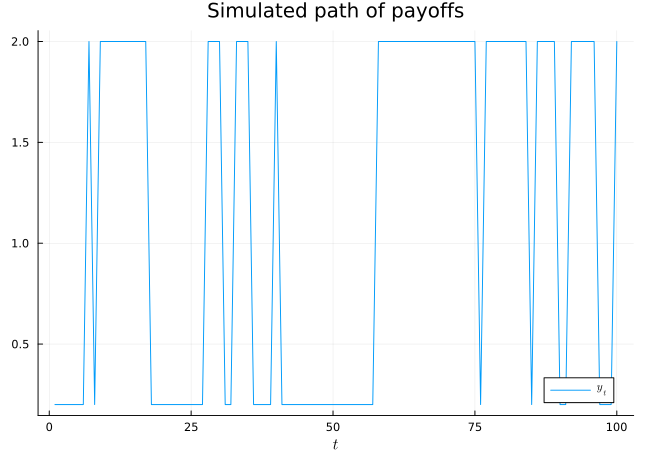

In [21]:
# sample code for simpler problem
P = [0.8 0.2; 0.1 0.9] # transition matrix, consistent with ordering of payoffs
y = [0.2, 2.0]  # payoffs in each state
mc = MarkovChain(P, y) # create a MarkovChain object with those state values and the transition matrix
init = 1  # i.e the state index, not the initial payoff value
T = 100
y_sim = simulate(mc, T; init) # simulate T periods of the Markov chain starting in state = init
plot(1:T, y_sim, xlabel = L"t", label = L"y_t", title = "Simulated path of payoffs")

The next code simulates a path of $N$ possible realizations of these
simulated payoffs, then calculates the expected discounted value of
these payoffs over the $T$ periods for a risk-neutral agent with
discount factor $\beta = 0.9$.

In [22]:
N = 5000
T = 500
beta = 0.9
y_sims = [simulate(mc, T; init) for _ in 1:N]
discounted_y_sims = [sum(beta^(t-1) * y_sim[t] for t in 1:T) for y_sim in y_sims]
simulated_EPV = mean(discounted_y_sims)

10.61791818192407

### Part (a)

Consider the formula, which comes from [Finite Markov Chain
Notes](https://julia.quantecon.org/introduction_dynamics/finite_markov.html#expectations-of-geometric-sums),

$$
v_0 = \mathbb{E}_0\left\{\sum_{t=0}^{\infty}\beta^t y_t \, | \, y_0 = 0.1\right\}
$$

In [23]:
 (I - beta * P) \ y

2-element Vector{Float64}:
 10.756756756756769
 15.621621621621633

Should we expect the simulation above to roughly match this calculation?
Where would the sources of uncertainty be?

(double click to edit your answer)

### Part (b)

Consider a new problem along the lines of this code.

There are 4 possible states of period payoffs (a random variable $Y_t$)
for a new firm, with a time-invariant probability to transition between
them:

1.  While in the R&D state (`R`), the firm gets payoffs of $y_R < 0$
    (i.e., at a loss) which must be maintained to continue research.
2.  Once a innovation has occurred the profits can be either high or low
    profits (`H`) or (`L`) which we denote $y_H > y_L > 0$ respectively.
3.  There is always the probability that a competitor drives the firm
    out of business (`X`), in which case the firm gets a payoff of
    $y_X = 0$ because the firm has exited.

The transition probabilities are time-invariant and are as follows:

1.  In the `R` state with $\lambda \in (0,1)$ each period they make a
    breakthrough and enter the `H` state. No direct movement from `R` to
    `L` or `X`.
2.  In `H` they have a probability $\mu \in (0,1)$ of moving to `L`. No
    direct movement occurs to `R` or `X`.
3.  In `L` they have a probability $\eta \in (0,1)$ of making a good
    discovery again and transitioning back to the `H`. Otherwise, there
    is a $\alpha \in (0, 1 - \eta)$ probability of a competitor driving
    them out of business to `X`.
4.  If they enter `X` (which can only occur from `L`) then the firm
    permanently exits.

An investor is considering how to value a firm with these cash flows.
Firms always start in the `R` state.

Modify our code above to implement this new Markov chain and simulate a
path of payoffs. Parameter values are provided below

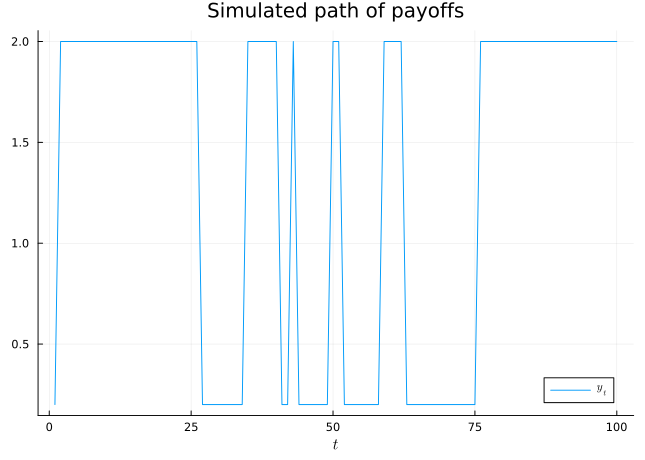

In [25]:
# parameter values
lambda = 0.2
mu = 0.3
eta = 0.4
alpha = 0.05
beta = 0.9
y_R = -0.2
y_L = 1.0
y_H = 2.0
y_X = 0.0

# Old code below, modify to implement the new model/markov chains
# clearly describe the ordering of your states.

# sample code for simpler problem
P = [0.8 0.2; 0.1 0.9] # transition matrix, consistent with ordering of payoffs
y = [0.2, 2.0]  # payoffs in each state
mc = MarkovChain(P, y) # create a MarkovChain object with those state values and the transition matrix
init = 1  # i.e the state index, not the initial payoff value
T = 100
y_sim = simulate(mc, T; init) # simulate T periods of the Markov chain starting in state = init
plot(1:T, y_sim, xlabel = L"t", label = L"y_t", title = "Simulated path of payoffs")

Use this new markov chain to simulate a number of cashflows and
calculate their present discounted value

In [27]:
N = 1000
T = 100
beta = 0.9
y_sims = [simulate(mc, T; init) for _ in 1:N]
discounted_y_sims = [sum(beta^(t-1) * y_sim[t] for t in 1:T) for y_sim in y_sims]
simulated_EPV = mean(discounted_y_sims)

8.49364371327928

And investigate how well it does vs. the full solution

In [28]:
v = (I - beta * P) \ y
v[1] # i.e., first state

8.464265795554143

Does this simulation do a better job of matching the explicit solution
than the simulation in part (a)? If so, any idea why?

(double click to edit your answer)

### Part (c)

Now consider the case where research is more costly, and $y_R = -2.575$,
but otherwise the parameters are the same.

In [30]:
# modify code here

Is this a good investment?

(double click to edit your answer)